## What happens when we only make detections using the NCHR station?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from obspy.core.event import read_events
import obspy
import eqcorrscan
import eqcorrscan.core.match_filter.template as template
from obspy.clients.fdsn.client import Client
from eqcorrscan.core.template_gen import template_gen
from eqcorrscan import Tribe
from datetime import datetime
client = Client('IRIS')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = '/Users/zoekrauss/endeavour_clustering/detections_sep2017_enwf/'
t1 = datetime(2017,9,1)
t2 = datetime(2017,10,1)

In [ ]:
def read_detections(path,t1,t2):
    
    time_bins = pd.to_datetime(np.arange(t1,t2,pd.Timedelta(1,'days')))
    
    parties = []
    for t in time_bins:
        pfile = path + 'party_' + t.strftime('%m_%d_%Y') + '.tgz'
        party = eqcorrscan.core.match_filter.party.Party().read(pfile)
        if len(party.families) > 0:
            parties.append(party)
        else:
            print('Detection did not work on ' + t.strftime('%m_%d_%Y'))

    # Combine the results from separate days into one party
    families = []
    num_templates = len(parties[0].families)
    for i in range(num_templates):
        fam_list = [p[i] for p in parties]
        fam = fam_list[0]
        for f in fam_list[1:]:
            fam = fam.append(f)
        families.append(fam)
    party = eqcorrscan.core.match_filter.party.Party(families=families)
    
    return party

In [ ]:
party = read_detections(path,t1,t2)

In [28]:
for f in party:
    print(f)

Family of 1 detections from template growclust5_ev520234
Family of 2 detections from template growclust6_ev520343
Family of 1 detections from template growclust3_ev520909
Family of 0 detections from template growclust1_ev519970
Family of 0 detections from template growclust2_ev520643
Family of 2 detections from template growclust17_ev519551
Family of 1 detections from template growclust4_ev519904
Family of 3 detections from template growclust10_ev519520
Family of 13 detections from template growclust16_ev520891


## Below is for av_chan_corr=0.7

In [ ]:
fig = plt.figure(figsize=(10,15))
axs = fig.subplots(len(party.families), 1, gridspec_kw={'hspace': 0.5},sharey=True,sharex=True)

for i,family in enumerate(party):
    times = [detection.detect_time.datetime for detection in family.detections]
    vals = [detection.detect_val for detection in family.detections]
    thresh = [detection.threshold for detection in family.detections]
    chans = [detection.no_chans for detection in family.detections]
    av_chan_corrs = []
    for j,val in enumerate(vals):
        av_chan_corrs.append((vals[j]/chans[j]))
    
    if len(times) > 0:
        axs[i].stem(times,av_chan_corrs)
        axs[i].stem(family.template.event.origins[0].time.datetime,1,'r')
    axs[i].axhline(1,color='k',linestyle='--')
    axs[i].set_ylim(0,1)
    axs[i].set_title(family.template.name)

## Below is for av_chan_corr=0.85

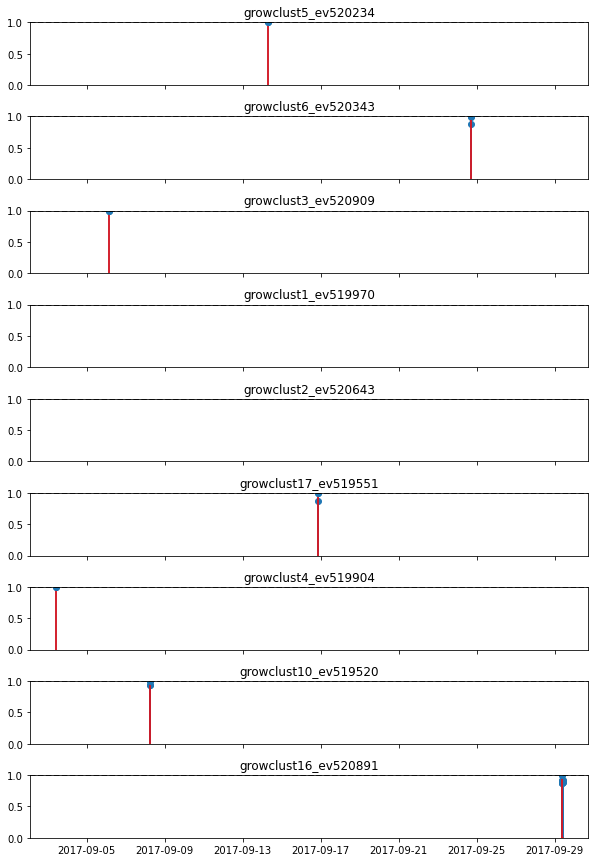

In [29]:
fig = plt.figure(figsize=(10,15))
axs = fig.subplots(len(party.families), 1, gridspec_kw={'hspace': 0.5},sharey=True,sharex=True)

for i,family in enumerate(party):
    times = [detection.detect_time.datetime for detection in family.detections]
    vals = [detection.detect_val for detection in family.detections]
    thresh = [detection.threshold for detection in family.detections]
    chans = [detection.no_chans for detection in family.detections]
    av_chan_corrs = []
    for j,val in enumerate(vals):
        av_chan_corrs.append((vals[j]/chans[j]))
    
    if len(times) > 0:
        axs[i].stem(times,av_chan_corrs)
        axs[i].stem(family.template.event.origins[0].time.datetime,1,'r')
    axs[i].axhline(1,color='k',linestyle='--')
    axs[i].set_ylim(0,1)
    axs[i].set_title(family.template.name)

## Visually confirming each template set that had > 1 detection

A cut-off of 0.85 gets some, but not all.

Growclust6 - the last 3 may be solid, all on 9-24.

Growclust17- looks like a few real ones on 9-16

Growclust10- at least 3 real ones starting on 9-8, may be a few noisier ones as well.

Growclust16- quite a few on 9-29!


In [ ]:
family = party[8]
evs = [det.event for det in family.detections]
cat = obspy.core.event.Catalog(events=evs)
cat.append(family.template.event)

temp = party[8].template.event
template_index = -1 # Index of detected template
for i,det in enumerate(party[8].detections):

    
    times = [p.time for p in det.event.picks]
    t1 = min(times)-2
    t2 = max(times)+2
    stations = [p.waveform_id.station_code for p in det.event.picks]
    chans = [p.waveform_id.channel_code for p in det.event.picks]
    stations = ",".join(np.unique(stations))
    chans = ",".join(np.unique(chans))
    st = client.get_waveforms('NV',stations,'*',chans,t1,t2)
    st.filter('bandpass',freqmin=8,freqmax=35)
    st = st.taper(max_percentage=0.5)
    st.sort()
    
    # Average channel correlation:
    print(event_corr([template_index,i]))
    
    fig = st.plot(handle=True,size=[800,600]);
    for i in range(len(fig.get_axes())):
        fig.get_axes()[i].vlines(x=min(times).datetime,ymin=-3000,ymax=3000,colors ='r',linewidth=1)
        fig.get_axes()[i].vlines(x=max(times).datetime,ymin=-3000,ymax=3000,colors ='r',linewidth=1)
    
    plt.show()

In [ ]:
family = party[11]
evs = [det.event for det in family.detections]
cat = obspy.core.event.Catalog(events=evs)
cat.append(family.template.event)

temp = party[11].template.event
template_index = -1 # Index of detected template
for i,det in enumerate(party[11].detections):

    
    times = [p.time for p in det.event.picks]
    t1 = min(times)-2
    t2 = max(times)+2
    stations = [p.waveform_id.station_code for p in det.event.picks]
    chans = [p.waveform_id.channel_code for p in det.event.picks]
    stations = ",".join(np.unique(stations))
    chans = ",".join(np.unique(chans))
    st = client.get_waveforms('NV',stations,'*',chans,t1,t2)
    st.filter('bandpass',freqmin=8,freqmax=35)
    st = st.taper(max_percentage=0.5)
    st.sort()
    
    # Average channel correlation:
    print('Average correlation of ' + str(av_chan_corrs[i]))
    print(event_corr([template_index,i]))
    

    fig = st.plot(handle=True,size=[800,600]);
    for i in range(len(fig.get_axes())):
        fig.get_axes()[i].vlines(x=min(times).datetime,ymin=-3000,ymax=3000,colors ='r',linewidth=1)
        fig.get_axes()[i].vlines(x=max(times).datetime,ymin=-3000,ymax=3000,colors ='r',linewidth=1)
    
    plt.show()

In [ ]:
family = party[10]
evs = [det.event for det in family.detections]
cat = obspy.core.event.Catalog(events=evs)
cat.append(family.template.event)

temp = party[10].template.event
template_index = -1 # Index of detected template
for i,det in enumerate(party[10].detections):

    
    times = [p.time for p in det.event.picks]
    t1 = min(times)-2
    t2 = max(times)+2
    stations = [p.waveform_id.station_code for p in det.event.picks]
    chans = [p.waveform_id.channel_code for p in det.event.picks]
    stations = ",".join(np.unique(stations))
    chans = ",".join(np.unique(chans))
    st = client.get_waveforms('NV',stations,'*',chans,t1,t2)
    st.filter('bandpass',freqmin=8,freqmax=35)
    st = st.taper(max_percentage=0.5)
    st.sort()
    
    # Average channel correlation:
    print('Average correlation of ' + str(det.detect_val/2))
    print(event_corr([template_index,i]))
    

    fig = st.plot(handle=True,size=[800,600]);
    for i in range(len(fig.get_axes())):
        fig.get_axes()[i].vlines(x=min(times).datetime,ymin=-3000,ymax=3000,colors ='r',linewidth=1)
        fig.get_axes()[i].vlines(x=max(times).datetime,ymin=-3000,ymax=3000,colors ='r',linewidth=1)
    
    plt.show()

## Let's just look at the detections around a single cluster

In [ ]:
temp_time = tribe[4].event.origins[0].time
print(temp_time)

In [ ]:
party = eqcorrscan.core.match_filter.party.Party().read('/Users/zoekrauss/endeavour_clustering/detections_sep2017_all/party_09_02_2017.tgz')

In [ ]:
for f in party:
    print(f)

In [ ]:
fig = plt.figure(figsize=(10,15))
axs = fig.subplots(len(party.families), 1, gridspec_kw={'hspace': 0.5},sharey=True,sharex=True)

for i,family in enumerate(party):
    times = [detection.detect_time.datetime for detection in family.detections]
    vals = [detection.detect_val for detection in family.detections]
    thresh = [detection.threshold for detection in family.detections]
    chans = [detection.no_chans for detection in family.detections]
    av_chan_corrs = []
    for j,val in enumerate(vals):
        av_chan_corrs.append((vals[j]/chans[j]))
    
    if len(times) > 0:
        axs[i].stem(times,av_chan_corrs)
    axs[i].axhline(1,color='k',linestyle='--')
    axs[i].set_ylim(0,1)

## The last cluster looks like a good candidate to look into- has a lot of more highly correlated events clustered in time.

In [ ]:
fig = plt.figure(figsize=(10,5))
axs = fig.subplots(1, 1, gridspec_kw={'hspace': 0},sharey=True,sharex=True)

family = party[11]
times = [detection.detect_time.datetime for detection in family.detections]
vals = [detection.detect_val for detection in family.detections]
thresh = [detection.threshold for detection in family.detections]
chans = [detection.no_chans for detection in family.detections]
av_chan_corrs = []
for j,val in enumerate(vals):
    av_chan_corrs.append((vals[j]/chans[j]))

if len(times) > 0:
    axs.stem(times,av_chan_corrs)
axs.axhline(1,color='k',linestyle='--')
axs.set_ylim(0,1)
axs.set_xlim(datetime(2017,9,29,6),datetime(2017,9,29,18))

## Based on that, let's cut off everything with an average below 0.4

In [ ]:
# Remove detections with average cross correlation < threshold

cc_thresh = 0.4

filtered_families = []
for family in party:
    keep = []
    for det in family:
        av_chan_corr = (det.detect_val/det.no_chans)
        if av_chan_corr > cc_thresh:
            keep.append(det)
    fam = eqcorrscan.core.match_filter.family.Family(family.template,detections=keep)
    filtered_families.append(fam)
    
party = eqcorrscan.core.match_filter.party.Party(families=filtered_families)

In [ ]:
fig = plt.figure(figsize=(10,5))
axs = fig.subplots(1, 1, gridspec_kw={'hspace': 0},sharey=True,sharex=True)

family = party[11]
times = [detection.detect_time.datetime for detection in family.detections]
vals = [detection.detect_val for detection in family.detections]
thresh = [detection.threshold for detection in family.detections]
chans = [detection.no_chans for detection in family.detections]
av_chan_corrs = []
for j,val in enumerate(vals):
    av_chan_corrs.append((vals[j]/chans[j]))

if len(times) > 0:
    axs.stem(times,av_chan_corrs)
axs.axhline(1,color='k',linestyle='--')
axs.set_ylim(0,1)
axs.set_xlim(datetime(2017,9,29,6),datetime(2017,9,29,18))

## Sure enough, wow, the waveforms look stunningly similar, as shown below, plotting each detection with the red lines denoting the earliest and latest picks for the detection. 

## The important thing to note is that the similarity is most clear on the NCHR channel- so we really just need to be paying attention to one instrument.

## As can be seen in all the examples below, the earthquakes that look like multiplets all have at least one channel with cc > 0.7. The average is not representative.

## Does the similarity between the NCHR channels change as time progresses?

In [ ]:
evs = [det.event for det in family.detections]
cat = obspy.core.event.Catalog(events=evs)

In [ ]:
evs[31]

In [ ]:
# Set up looping, so that we get all possible pairs of events but NO repeats!
import itertools
loop_ind = list(itertools.combinations(range(len(cat)),2))

In [ ]:
def pick_corr(phase,sta,chan,t1,t2):
    """
    Cross correlates two phase picks from the same channel and calculates their differential travel times
    This function pulls in the waveform data directly from Iris
    
    INPUT:
    phase: 'P' or 'S'; this determines the size of the window cut around the pick time
    sta: string, station code 
    chan: string, channel code
    t1: pick time of first pick as UTCDatetime
    t2: pick time of second pick as UTCDatetime
    ot1: origin time of the earthquake the first pick is for in UTCDatetime
    ot2: origin time of the earthquake the second pick is for in UTCDatetime
    
    RETURNS:
    value: maximum cross correlation value of the waveform cut around the two picks
    dtt: differential travel times of the two picks
    """
    
    if phase=='Z':
        t_off=[-0.3,0.5]
        t_off=[-1,1.5]
    if phase=='E':
        t_off = [-1,2.5]
        
    # Pull in waveforms longer than picks
    tr1 = client.get_waveforms('NV',sta,'',chan,t1-5,t1+5).detrend()
    tr2 = client.get_waveforms('NV',sta,'',chan,t2-5,t2+5).detrend()
    
    # Filter
    tr1.filter('bandpass',freqmin=8,freqmax=35)
    tr2.filter('bandpass',freqmin=8,freqmax=35)
    
    # Cut the waveforms around picks
    tr1.trim(starttime=t1+t_off[0],endtime=t1+t_off[1])
    tr2.trim(starttime=t2+t_off[0],endtime=t2+t_off[1])
    
    # Cross correlate waveforms, allowing them to shift relative to each other for the case of faulty picks
    xcor = obspy.signal.cross_correlation.correlate(tr1[0],tr2[0],100)
    shift,value = obspy.signal.cross_correlation.xcorr_max(xcor)
    
    
    return(value)


def event_corr(pair):
    """
    INPUT:
    A tuple of indices of events in the catalog
    
    For the two events corresponding to those indices, finds the common picks between them and calculates
    their cross correlation coefficient and differential travel times
    
    RETURNS:
    A numpy array designed to be easily written to a text file in the format needed for GrowClust
    Array has format ((ev1id,ev2id),(commonpick1,commonpick2,...))
    Where each commonpick array has the format (station,differential travel time,cross correlation coefficient,phase)
    """
    
    path = 'sep2017_mseed/'
    
    i = pair[0]
    j = pair[1]

    sta1 = [p.waveform_id.station_code for p in cat[i].picks]
    sta2 = [p.waveform_id.station_code for p in cat[j].picks]
    pha1 = [p.waveform_id.channel_code[2] for p in cat[i].picks]
    pha2 = [p.waveform_id.channel_code[2] for p in cat[j].picks]
    picks1 = [a+'_'+pha1[k] for k,a in enumerate(sta1)]
    picks2 = [a+'_'+pha2[k] for k,a in enumerate(sta2)]
    common_picks = list(set(picks1).intersection(set(picks2)))

    pick_arr = np.empty((len(common_picks),3),dtype=object)
    for k,p in enumerate(common_picks):
        # Find corresponding pick info within each event
        # Send to pick_corr to get information
        sta,phase = p.split('_')

        sta1_ind = [ ind for ind in range(len(sta1)) if sta1[ind] == sta ]
        pha1_ind = [ ind for ind in range(len(pha1)) if pha1[ind] == phase ]
        pick1_ind = list(set(sta1_ind).intersection(set(pha1_ind)))
        pick1 = cat[i].picks[pick1_ind[0]]

        sta2_ind = [ ind for ind in range(len(sta2)) if sta2[ind] == sta ]
        pha2_ind = [ ind for ind in range(len(pha2)) if pha2[ind] == phase ]
        pick2_ind = list(set(sta2_ind).intersection(set(pha2_ind)))
        pick2 = cat[j].picks[pick2_ind[0]]

        chan = pick1.waveform_id.channel_code
        xcor_val = pick_corr(phase,sta,chan,pick1.time,pick2.time)
        # xcor_val,dtt = pick_corr(phase,sta,chan,pick1.time,pick2.time,ot1,ot2)

        # Write station- and phase-specific line
        
        pick_arr[k][0]=sta
        pick_arr[k][1]=xcor_val
        pick_arr[k][2] = phase
        
    
    return(pick_arr)

In [ ]:
test = event_corr(loop_ind[34])

In [ ]:
test

In [ ]:
test